# Preprocessing PeloNet-Dataset

Data Suara yang digunakan di sini terdiri dari file suara buka_sengau, tutup Sengau, selain 2 diatas di latih juga data on dan off (sengau dan tidak sengau).Pertimbangan pemilihan dua kata tersebut adalah kemudahan pengucapan.
    Masing -masing data suara berdurasi 1 detik (kurang lebih) dengan frekuensi sampling sebesar 16 KHz.
    Ada perubahan syntax program di line 11 akibat API tensorflow yang tidak sinkron (Program fix tidak ada bug). Hasil program dapat dilihat dalam bentuk spectogram suara


tar -xzf AudioDataset_on_off_vokal.tar.gz -C speech_data


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.io import gfile
import tensorflow_io as tfio
from tensorflow.python.ops import gen_audio_ops as audio_ops
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from tensorflow.python.ops import gen_audio_ops as audio_ops
import ipywidgets as widgets
from IPython.display import display
from training_dashboard import TrainingDashboard

In [2]:
SPEECH_DATA='speech_data'

In [3]:
EXPECTED_SAMPLES=16000
NOISE_FLOOR=0.1
MINIMUM_VOICE_LENGTH=EXPECTED_SAMPLES/4

In [4]:
# list folder data yang akan diproses
command_words = [
    'vokaliii',
    'vokaleee',
    'forward',
    'backward',
    '_invalid',
]
nonsense_words = [
   'stop',
    'go',
    'on',
    'off',
    'up',
    'down',
    'learn',
    'yes',
    'no',
    'zero',
    'one',
    'two',
    'three',
    'four',
    'five',
    'six',
    'seven',
    'eight',
    'nine',
    'follow',
    'tree',
    'bed',
    'bird',
    'cat',
    'dog',
    'happy',
    'house',
    'marvin',
    'sheila',
    'visual',
    'wow',
    'vokaluuu',
    'vokalaaa',
]

In [5]:

def get_files(word):
    return gfile.glob(SPEECH_DATA + '/'+word+'/*.wav')
def get_voice_position(audio, noise_floor):
    audio = audio - np.mean(audio)
    audio = audio / np.max(np.abs(audio))
    return tfio.audio.trim(audio, axis=0, epsilon=noise_floor)
def get_voice_length(audio, noise_floor):
    position = get_voice_position(audio, noise_floor)
    return (position[1] - position[0]).numpy()
def is_voice_present(audio, noise_floor, required_length):
    voice_length = get_voice_length(audio, noise_floor)
    return voice_length >= required_length
def is_correct_length(audio, expected_length):
    return (audio.shape[0]==expected_length).numpy()
def is_valid_file(file_name):
    # ambil audio file
    audio_tensor = tfio.audio.AudioIOTensor(file_name)
    # cek durasi file audio
    if not is_correct_length(audio_tensor, EXPECTED_SAMPLES):
        return False
    # konversi ke dalam bentuk array
    audio = tf.cast(audio_tensor[:], tf.float32)
    audio = audio - np.mean(audio)
    audio = audio / np.max(np.abs(audio))
    
    if not is_voice_present(audio, NOISE_FLOOR, MINIMUM_VOICE_LENGTH):
        return False
    return True


In [6]:
def get_spectrogram(audio):
    # normalisasi Audio
    audio = audio - np.mean(audio)
    audio = audio / np.max(np.abs(audio))
    # create the spectrogram
    spectrogram = audio_ops.audio_spectrogram(audio,
                                              window_size=320,
                                              stride=160,
                                              magnitude_squared=True).numpy()
    # Mengurangi jumlah Frequency Bin atau windowing dengan Hamming window
    spectrogram = tf.nn.pool(
        input=tf.expand_dims(spectrogram, -1),
        window_shape=[1, 6],
        strides=[1, 6],
        pooling_type='AVG',
        padding='SAME')
    spectrogram = tf.squeeze(spectrogram, axis=0)
    spectrogram = np.log10(spectrogram + 1e-6)
    return spectrogram

In [7]:
# Ekstarksi Ciri Audio Menjadi spektrogram
def process_file(file_path):
    # Fungsi load  audio file
    audio_tensor = tfio.audio.AudioIOTensor(file_path)
    # Fungsi Konversi besaran amplitudo menjadi array dengan skala float -1 dan 1
    audio = tf.cast(audio_tensor[:], tf.float32)
    audio = audio - np.mean(audio)
    audio = audio / np.max(np.abs(audio))
    # Fungsi Reposisi Audio Sample 
    voice_start, voice_end = get_voice_position(audio, NOISE_FLOOR)
    end_gap=len(audio) - voice_end
    random_offset = np.random.uniform(0, voice_start+end_gap)
    audio = np.roll(audio,-random_offset+end_gap)
    # Augmentasi data dengan menambahkan background noise
    background_volume = np.random.uniform(0, 0.1)
    # Fungsi get the background noise File
    background_files = get_files('_background_noise_')
    background_file = np.random.choice(background_files)
    background_tensor = tfio.audio.AudioIOTensor(background_file)
    background_start = np.random.randint(0, len(background_tensor) - 16000)
    # Normalisasi Background noise 
    background = tf.cast(background_tensor[background_start:background_start+16000], tf.float32)
    background = background - np.mean(background)
    background = background / np.max(np.abs(background))
    # Augmentasi data 2 dengan mencampur hasil Background noise dengan dataset PeloNet
    audio = audio + background_volume * background
    # Fungsi get the spectrogram
    return get_spectrogram(audio)

In [8]:
train = []
validate = []
test = []

TRAIN_SIZE=0.8
VALIDATION_SIZE=0.1
TEST_SIZE=0.1

In [9]:
def process_files(file_names, label, repeat=1):
    file_names = tf.repeat(file_names, repeat).numpy()
    return [(process_file(file_name), label) for file_name in tqdm(file_names, desc=f"{word} ({label})", leave=False)]

# Fungsi Proses per kata ke spektogram dan label menggunakan one hot encoding
def process_word(word, label, repeat=1):
    # Memberi List Kata dan mengkategori dalam filenames
    file_names = [file_name for file_name in tqdm(get_files(word), desc="Checking", leave=False) if is_valid_file(file_name)]
    # randomly shuffle filenames
    np.random.shuffle(file_names)
    # memisahkan file menjadi train, validasi dan testing 
    train_size=int(TRAIN_SIZE*len(file_names))
    validation_size=int(VALIDATION_SIZE*len(file_names))
    test_size=int(TEST_SIZE*len(file_names))
    # Fungsi menggambil sampel training
    train.extend(
        process_files(
            file_names[:train_size],
            label,
            repeat=repeat
        )
    )
    # Sampel Validasi 
    validate.extend(
        process_files(
            file_names[train_size:train_size+validation_size],
            label,
            repeat=repeat
        )
    )
    # Sampel test
    test.extend(
        process_files(
            file_names[train_size+validation_size:],
            label,
            repeat=repeat
        )
    )

# Proses semua kata Common Words
for word in tqdm(command_words, desc="Processing words"):
    if '_' not in word:
        repeat = 200 if word in ('vokaliii,vokaleee') else 40
        process_word(word, command_words.index(word), repeat=repeat)
        
# dan Kata nonsense words
for word in tqdm(nonsense_words, desc="Processing words"):
    if '_' not in word:
        process_word(word, command_words.index('_invalid'), repeat=1)

print(len(train), len(test), len(validate))

Processing words:   0%|          | 0/5 [00:00<?, ?it/s]

Checking:   0%|          | 0/99 [00:00<?, ?it/s]

vokaliii (0):   0%|          | 0/15800 [00:00<?, ?it/s]

vokaliii (0):   0%|          | 0/1800 [00:00<?, ?it/s]

vokaliii (0):   0%|          | 0/2200 [00:00<?, ?it/s]

Checking:   0%|          | 0/120 [00:00<?, ?it/s]

vokaleee (1):   0%|          | 0/19200 [00:00<?, ?it/s]

vokaleee (1):   0%|          | 0/2400 [00:00<?, ?it/s]

vokaleee (1):   0%|          | 0/2400 [00:00<?, ?it/s]

Checking:   0%|          | 0/1557 [00:00<?, ?it/s]

forward (2):   0%|          | 0/44520 [00:00<?, ?it/s]

forward (2):   0%|          | 0/5560 [00:00<?, ?it/s]

forward (2):   0%|          | 0/5600 [00:00<?, ?it/s]

Checking:   0%|          | 0/1664 [00:00<?, ?it/s]

backward (3):   0%|          | 0/49000 [00:00<?, ?it/s]

backward (3):   0%|          | 0/6120 [00:00<?, ?it/s]

backward (3):   0%|          | 0/6160 [00:00<?, ?it/s]

Processing words:   0%|          | 0/33 [00:00<?, ?it/s]

Checking:   0%|          | 0/3872 [00:00<?, ?it/s]

stop (4):   0%|          | 0/2001 [00:00<?, ?it/s]

stop (4):   0%|          | 0/250 [00:00<?, ?it/s]

stop (4):   0%|          | 0/251 [00:00<?, ?it/s]

Checking:   0%|          | 0/3880 [00:00<?, ?it/s]

go (4):   0%|          | 0/2157 [00:00<?, ?it/s]

go (4):   0%|          | 0/269 [00:00<?, ?it/s]

go (4):   0%|          | 0/271 [00:00<?, ?it/s]

Checking:   0%|          | 0/3845 [00:00<?, ?it/s]

on (4):   0%|          | 0/2390 [00:00<?, ?it/s]

on (4):   0%|          | 0/298 [00:00<?, ?it/s]

on (4):   0%|          | 0/300 [00:00<?, ?it/s]

Checking:   0%|          | 0/3745 [00:00<?, ?it/s]

off (4):   0%|          | 0/1188 [00:00<?, ?it/s]

off (4):   0%|          | 0/148 [00:00<?, ?it/s]

off (4):   0%|          | 0/150 [00:00<?, ?it/s]

Checking:   0%|          | 0/3723 [00:00<?, ?it/s]

up (4):   0%|          | 0/790 [00:00<?, ?it/s]

up (4):   0%|          | 0/98 [00:00<?, ?it/s]

up (4):   0%|          | 0/100 [00:00<?, ?it/s]

Checking:   0%|          | 0/3917 [00:00<?, ?it/s]

down (4):   0%|          | 0/2623 [00:00<?, ?it/s]

down (4):   0%|          | 0/327 [00:00<?, ?it/s]

down (4):   0%|          | 0/329 [00:00<?, ?it/s]

Checking:   0%|          | 0/1575 [00:00<?, ?it/s]

learn (4):   0%|          | 0/1096 [00:00<?, ?it/s]

learn (4):   0%|          | 0/137 [00:00<?, ?it/s]

learn (4):   0%|          | 0/137 [00:00<?, ?it/s]

Checking:   0%|          | 0/4044 [00:00<?, ?it/s]

yes (4):   0%|          | 0/2364 [00:00<?, ?it/s]

yes (4):   0%|          | 0/295 [00:00<?, ?it/s]

yes (4):   0%|          | 0/297 [00:00<?, ?it/s]

Checking:   0%|          | 0/3941 [00:00<?, ?it/s]

no (4):   0%|          | 0/2464 [00:00<?, ?it/s]

no (4):   0%|          | 0/308 [00:00<?, ?it/s]

no (4):   0%|          | 0/309 [00:00<?, ?it/s]

Checking:   0%|          | 0/4052 [00:00<?, ?it/s]

zero (4):   0%|          | 0/2957 [00:00<?, ?it/s]

zero (4):   0%|          | 0/369 [00:00<?, ?it/s]

zero (4):   0%|          | 0/371 [00:00<?, ?it/s]

Checking:   0%|          | 0/3890 [00:00<?, ?it/s]

one (4):   0%|          | 0/2324 [00:00<?, ?it/s]

one (4):   0%|          | 0/290 [00:00<?, ?it/s]

one (4):   0%|          | 0/292 [00:00<?, ?it/s]

Checking:   0%|          | 0/3880 [00:00<?, ?it/s]

two (4):   0%|          | 0/2164 [00:00<?, ?it/s]

two (4):   0%|          | 0/270 [00:00<?, ?it/s]

two (4):   0%|          | 0/271 [00:00<?, ?it/s]

Checking:   0%|          | 0/3727 [00:00<?, ?it/s]

three (4):   0%|          | 0/2276 [00:00<?, ?it/s]

three (4):   0%|          | 0/284 [00:00<?, ?it/s]

three (4):   0%|          | 0/286 [00:00<?, ?it/s]

Checking:   0%|          | 0/3728 [00:00<?, ?it/s]

four (4):   0%|          | 0/2250 [00:00<?, ?it/s]

four (4):   0%|          | 0/281 [00:00<?, ?it/s]

four (4):   0%|          | 0/282 [00:00<?, ?it/s]

Checking:   0%|          | 0/4052 [00:00<?, ?it/s]

five (4):   0%|          | 0/2376 [00:00<?, ?it/s]

five (4):   0%|          | 0/297 [00:00<?, ?it/s]

five (4):   0%|          | 0/297 [00:00<?, ?it/s]

Checking:   0%|          | 0/3860 [00:00<?, ?it/s]

six (4):   0%|          | 0/2321 [00:00<?, ?it/s]

six (4):   0%|          | 0/290 [00:00<?, ?it/s]

six (4):   0%|          | 0/291 [00:00<?, ?it/s]

Checking:   0%|          | 0/3998 [00:00<?, ?it/s]

seven (4):   0%|          | 0/2753 [00:00<?, ?it/s]

seven (4):   0%|          | 0/344 [00:00<?, ?it/s]

seven (4):   0%|          | 0/345 [00:00<?, ?it/s]

Checking:   0%|          | 0/3787 [00:00<?, ?it/s]

eight (4):   0%|          | 0/1858 [00:00<?, ?it/s]

eight (4):   0%|          | 0/232 [00:00<?, ?it/s]

eight (4):   0%|          | 0/233 [00:00<?, ?it/s]

Checking:   0%|          | 0/3934 [00:00<?, ?it/s]

nine (4):   0%|          | 0/2758 [00:00<?, ?it/s]

nine (4):   0%|          | 0/344 [00:00<?, ?it/s]

nine (4):   0%|          | 0/346 [00:00<?, ?it/s]

Checking:   0%|          | 0/1579 [00:00<?, ?it/s]

follow (4):   0%|          | 0/1063 [00:00<?, ?it/s]

follow (4):   0%|          | 0/132 [00:00<?, ?it/s]

follow (4):   0%|          | 0/134 [00:00<?, ?it/s]

Checking:   0%|          | 0/1759 [00:00<?, ?it/s]

tree (4):   0%|          | 0/1118 [00:00<?, ?it/s]

tree (4):   0%|          | 0/139 [00:00<?, ?it/s]

tree (4):   0%|          | 0/141 [00:00<?, ?it/s]

Checking:   0%|          | 0/2014 [00:00<?, ?it/s]

bed (4):   0%|          | 0/998 [00:00<?, ?it/s]

bed (4):   0%|          | 0/124 [00:00<?, ?it/s]

bed (4):   0%|          | 0/126 [00:00<?, ?it/s]

Checking:   0%|          | 0/2064 [00:00<?, ?it/s]

bird (4):   0%|          | 0/1293 [00:00<?, ?it/s]

bird (4):   0%|          | 0/161 [00:00<?, ?it/s]

bird (4):   0%|          | 0/163 [00:00<?, ?it/s]

Checking:   0%|          | 0/2031 [00:00<?, ?it/s]

cat (4):   0%|          | 0/921 [00:00<?, ?it/s]

cat (4):   0%|          | 0/115 [00:00<?, ?it/s]

cat (4):   0%|          | 0/116 [00:00<?, ?it/s]

Checking:   0%|          | 0/2128 [00:00<?, ?it/s]

dog (4):   0%|          | 0/1306 [00:00<?, ?it/s]

dog (4):   0%|          | 0/163 [00:00<?, ?it/s]

dog (4):   0%|          | 0/164 [00:00<?, ?it/s]

Checking:   0%|          | 0/2054 [00:00<?, ?it/s]

happy (4):   0%|          | 0/1285 [00:00<?, ?it/s]

happy (4):   0%|          | 0/160 [00:00<?, ?it/s]

happy (4):   0%|          | 0/162 [00:00<?, ?it/s]

Checking:   0%|          | 0/2113 [00:00<?, ?it/s]

house (4):   0%|          | 0/1132 [00:00<?, ?it/s]

house (4):   0%|          | 0/141 [00:00<?, ?it/s]

house (4):   0%|          | 0/142 [00:00<?, ?it/s]

Checking:   0%|          | 0/2100 [00:00<?, ?it/s]

marvin (4):   0%|          | 0/1438 [00:00<?, ?it/s]

marvin (4):   0%|          | 0/179 [00:00<?, ?it/s]

marvin (4):   0%|          | 0/181 [00:00<?, ?it/s]

Checking:   0%|          | 0/2022 [00:00<?, ?it/s]

sheila (4):   0%|          | 0/1384 [00:00<?, ?it/s]

sheila (4):   0%|          | 0/173 [00:00<?, ?it/s]

sheila (4):   0%|          | 0/173 [00:00<?, ?it/s]

Checking:   0%|          | 0/1592 [00:00<?, ?it/s]

visual (4):   0%|          | 0/1149 [00:00<?, ?it/s]

visual (4):   0%|          | 0/143 [00:00<?, ?it/s]

visual (4):   0%|          | 0/145 [00:00<?, ?it/s]

Checking:   0%|          | 0/2123 [00:00<?, ?it/s]

wow (4):   0%|          | 0/1356 [00:00<?, ?it/s]

wow (4):   0%|          | 0/169 [00:00<?, ?it/s]

wow (4):   0%|          | 0/170 [00:00<?, ?it/s]

Checking:   0%|          | 0/10 [00:00<?, ?it/s]

vokaluuu (4):   0%|          | 0/8 [00:00<?, ?it/s]

vokaluuu (4):   0%|          | 0/1 [00:00<?, ?it/s]

vokaluuu (4):   0%|          | 0/1 [00:00<?, ?it/s]

Checking:   0%|          | 0/10 [00:00<?, ?it/s]

vokalaaa (4):   0%|          | 0/8 [00:00<?, ?it/s]

vokalaaa (4):   0%|          | 0/1 [00:00<?, ?it/s]

vokalaaa (4):   0%|          | 0/1 [00:00<?, ?it/s]

184089 23337 22812


In [11]:
# Melakukan hal yang sama pada background noise 
def process_background(file_name, label):
    audio_tensor = tfio.audio.AudioIOTensor(file_name)
    audio = tf.cast(audio_tensor[:], tf.float32)
    audio_length = len(audio)
    samples = []
    for section_start in tqdm(range(0, audio_length-EXPECTED_SAMPLES, 16000), desc=file_name, leave=False):
        section_end = section_start + EXPECTED_SAMPLES
        section = audio[section_start:section_end]
        spectrogram = get_spectrogram(section)
        samples.append((spectrogram, label))

    for section_index in tqdm(range(1000), desc="Simulated Words", leave=False):
        section_start = np.random.randint(0, audio_length - EXPECTED_SAMPLES)
        section_end = section_start + EXPECTED_SAMPLES
        section = np.reshape(audio[section_start:section_end], (EXPECTED_SAMPLES))

        result = np.zeros((EXPECTED_SAMPLES))
        voice_length = np.random.randint(MINIMUM_VOICE_LENGTH/2, EXPECTED_SAMPLES)
        voice_start = np.random.randint(0, EXPECTED_SAMPLES - voice_length)
        hamming = np.hamming(voice_length)
        result[voice_start:voice_start+voice_length] = hamming * section[voice_start:voice_start+voice_length]
        spectrogram = get_spectrogram(np.reshape(section, (16000, 1)))
        samples.append((spectrogram, label))
        
    
    np.random.shuffle(samples)
    
    train_size=int(TRAIN_SIZE*len(samples))
    validation_size=int(VALIDATION_SIZE*len(samples))
    test_size=int(TEST_SIZE*len(samples))
    
    train.extend(samples[:train_size])

    validate.extend(samples[train_size:train_size+validation_size])

    test.extend(samples[train_size+validation_size:])

        
for file_name in tqdm(get_files('_background_noise_'), desc="Processing Background Noise"):
    process_background(file_name, command_words.index("_invalid"))
    
print(len(train), len(test), len(validate))

Processing Background Noise:   0%|          | 0/6 [00:00<?, ?it/s]

speech_data\_background_noise_\doing_the_dishes.wav:   0%|          | 0/95 [00:00<?, ?it/s]

Simulated Words:   0%|          | 0/1000 [00:00<?, ?it/s]

speech_data\_background_noise_\dude_miaowing.wav:   0%|          | 0/61 [00:00<?, ?it/s]

Simulated Words:   0%|          | 0/1000 [00:00<?, ?it/s]

speech_data\_background_noise_\exercise_bike.wav:   0%|          | 0/61 [00:00<?, ?it/s]

Simulated Words:   0%|          | 0/1000 [00:00<?, ?it/s]

speech_data\_background_noise_\pink_noise.wav:   0%|          | 0/59 [00:00<?, ?it/s]

Simulated Words:   0%|          | 0/1000 [00:00<?, ?it/s]

speech_data\_background_noise_\running_tap.wav:   0%|          | 0/61 [00:00<?, ?it/s]

Simulated Words:   0%|          | 0/1000 [00:00<?, ?it/s]

speech_data\_background_noise_\white_noise.wav:   0%|          | 0/59 [00:00<?, ?it/s]

Simulated Words:   0%|          | 0/1000 [00:00<?, ?it/s]

194317 24627 24086


In [12]:
def process_problem_noise(file_name, label):
    samples = []
    # load the audio file
    audio_tensor = tfio.audio.AudioIOTensor(file_name)
    audio = tf.cast(audio_tensor[:], tf.float32)
    audio_length = len(audio)
    samples = []
    for section_start in tqdm(range(0, audio_length-EXPECTED_SAMPLES, 800), desc=file_name, leave=False):
        section_end = section_start + EXPECTED_SAMPLES
        section = audio[section_start:section_end]
        spectrogram = get_spectrogram(section)
        samples.append((spectrogram, label))
        
    np.random.shuffle(samples)
    
    train_size=int(TRAIN_SIZE*len(samples))
    validation_size=int(VALIDATION_SIZE*len(samples))
    test_size=int(TEST_SIZE*len(samples))
    
    train.extend(samples[:train_size])
    validate.extend(samples[train_size:train_size+validation_size])
    test.extend(samples[train_size+validation_size:])


for file_name in tqdm(get_files("_problem_noise_"), desc="Processing problem noise"):
    process_problem_noise(file_name, command_words.index("_invalid"))

Processing problem noise: 0it [00:00, ?it/s]

In [13]:
print(len(train), len(test), len(validate))

194317 24627 24086


In [14]:
# randomise sasmpel data training
np.random.shuffle(train)

In [15]:
X_train, Y_train = zip(*train)
X_validate, Y_validate = zip(*validate)
X_test, Y_test = zip(*test)

In [16]:
# Save hasil generate spektrogram
np.savez_compressed(
    "training_spectrogram.npz",
    X=X_train, Y=Y_train)
print("Saved training data")
np.savez_compressed(
    "validation_spectrogram.npz",
    X=X_validate, Y=Y_validate)
print("Saved validation data")
np.savez_compressed(
    "test_spectrogram.npz",
    X=X_test, Y=Y_test)
print("Saved test data")

Saved training data
Saved validation data
Saved test data


In [17]:
# Menampilkan sampel gambar spektrogram 
IMG_WIDTH=X_train[0].shape[0]
IMG_HEIGHT=X_train[0].shape[1]

In [18]:
def plot_images2(images_arr, imageWidth, imageHeight):
    fig, axes = plt.subplots(2, 5, figsize=(10, 10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(np.reshape(img, (imageWidth, imageHeight)))
        ax.axis("off")
    plt.tight_layout()
    plt.show()
    

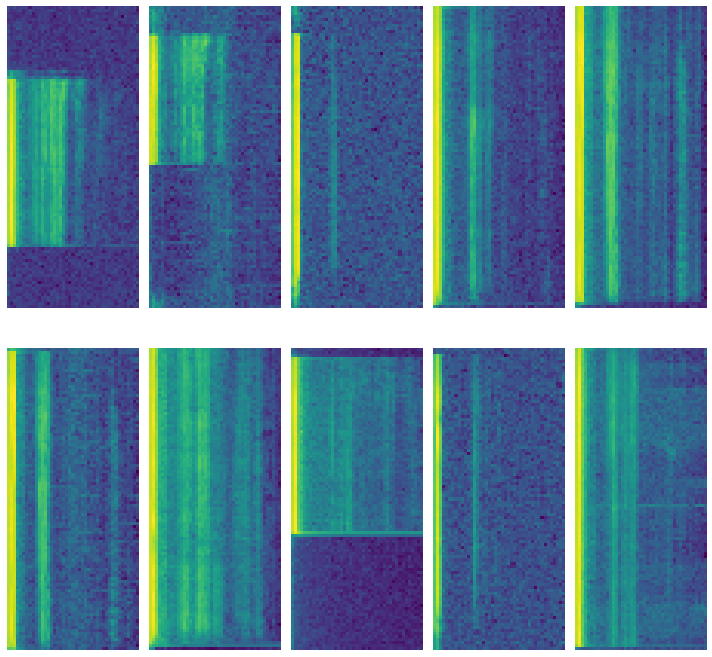

In [19]:
word_index = command_words.index("vokaliii")

X_right = np.array(X_train)[np.array(Y_train) == word_index]
plot_images2(X_right[:10], IMG_WIDTH, IMG_HEIGHT)

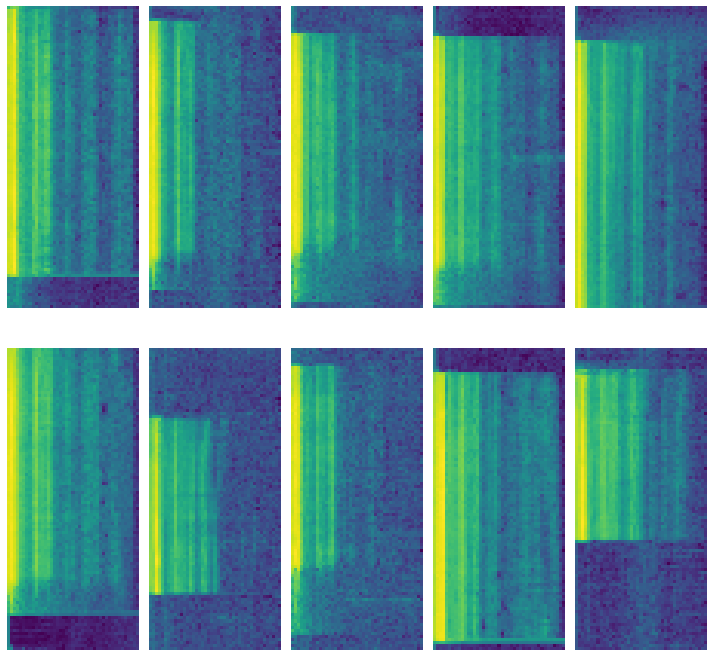

In [211]:
word_index = command_words.index("vokaleee")

X_right = np.array(X_train)[np.array(Y_train) == word_index]
plot_images2(X_right[:10], IMG_WIDTH, IMG_HEIGHT)

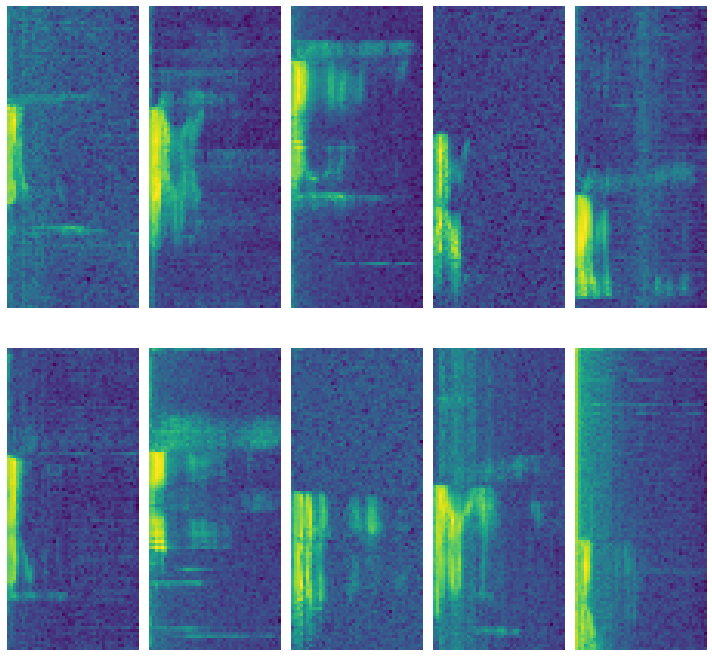

In [212]:
word_index = command_words.index("forward")

X_right = np.array(X_train)[np.array(Y_train) == word_index]
plot_images2(X_right[:10], IMG_WIDTH, IMG_HEIGHT)

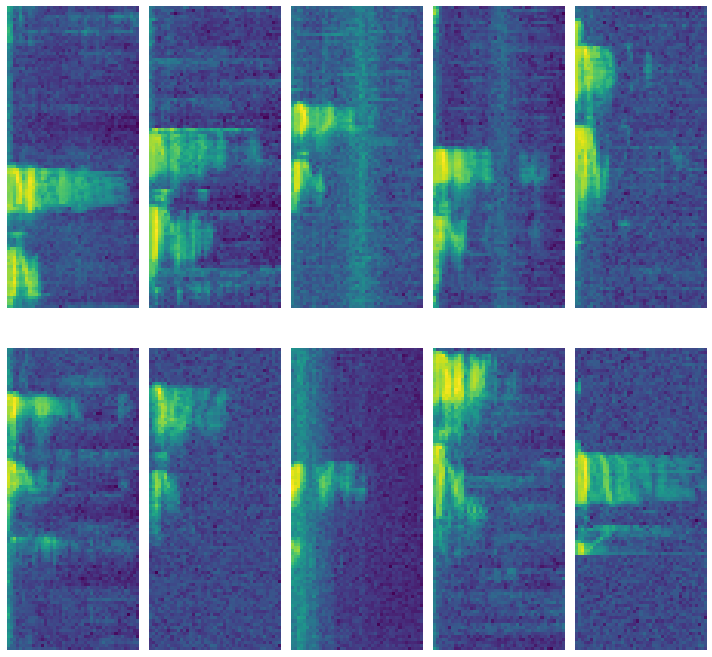

In [213]:
word_index = command_words.index("backward")

X_right = np.array(X_train)[np.array(Y_train) == word_index]
plot_images2(X_right[:10], IMG_WIDTH, IMG_HEIGHT)